In [69]:
from models.mc import hybridMonteCarlo
import models.benchmarks as bm
from models.longstaff import LSMC_Numpy, LSMC_OpenCL
from models.pso import PSO_Numpy, PSO_OpenCL_hybrid, PSO_OpenCL_scalar, PSO_OpenCL_scalar_fusion, PSO_OpenCL_vec, PSO_OpenCL_vec_fusion
from models.utils import checkOpenCL

import numpy as np
import matplotlib.pyplot as plt

In [70]:
checkOpenCL()


OpenCL Platforms and Devices
Platform - Name: Apple
Platform - Vendor: Apple
Platform - Version: OpenCL 1.2 (Mar  7 2025 21:04:06)
Platform - Profile: FULL_PROFILE
 --------------------------------------------------------
 Device - Name: Apple M3 Max
 Device - Type: ALL | GPU
 Device - Max Clock Speed: 1000 Mhz
 Device - Compute Units: 40
 Device - Global Memory: 48 GB
 Device - Constant Memory: 1 GB
 Device - Local Memory: 32 KB (LOCAL)
 Device - Max Buffer/Image Size: 9 GB
 Device - Max Work Group Size: 256
 Device - Float Atomics Supported: True




In [71]:
# S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 20000, 200, 105.0, 'P', 500
S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 20000, 2**8, 110.0, 'P', 2**10  
mc = hybridMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
print(f'{nPath} paths, {nPeriod} periods, {nFish} particles.\n')
print(f'St in shape {mc.St.shape}')

20000 paths, 256 periods, 1024 particles.

St in shape (20000, 256)


In [72]:
# St_full = np.concatenate( (np.full(shape=(nPath, 1), fill_value=S0), mcBase.St) , axis=1)
# St_full
# plt.plot(St_full.T, color="b", lw=.7, alpha=.7)
# plt.show()

In [73]:
prices = []
elapses = []
labels = []

In [74]:
# benchmarks
_, _ = bm.blackScholes(S0, K, r, sigma, T, opttype)
_, _ = bm.binomialEuroOption(S0, K, r, sigma, nPeriod, T, opttype)
_, _ = mc.getEuroOption_np()
_, _ = mc.getEuroOption_cl_optimized()
_, _ = bm.binomialAmericanOption(S0, K, r, sigma, nPeriod, T, opttype)

Black-Scholes price: 15.989035403985838 - 1.464374945499003 ms
Binomial European price: 15.999715488649372 - 4.07537491992116 ms
MonteCarlo Numpy European price: 16.0897390625 - 0.16650010365992785 ms
MonteCarlo OpenCL_GPU European price: 16.0897375 - 10.303125018253922 ms
Binomial American price: 16.513004914214047 - 1.989666954614222 ms


In [75]:
lsmc_np = LSMC_Numpy(mc, inverseType='benchmark_pinv')
p_lsmc_np, t_lsmc_np = lsmc_np.longstaff_schwartz_itm_path_fast()

lsmc_cl = LSMC_OpenCL(mc, preCalc="optimized")   
# lsmc_cl = LSMC_OpenCL(mc, inverseType='GJ')     
# lsmc_cl = LSMC_OpenCL(mc, inverseType='CA')     
p_lsmc_cl, t_lsmc_cl = lsmc_cl.longstaff_schwartz_itm_path_fast_hybrid()

Longstaff numpy price: 16.555792566874523 - 345.4547500004992 ms
Longstaff OpenCL_GPU price: 16.565616415574794 - 176.0546249570325 ms


In [76]:
prices.append(p_lsmc_np), prices.append(p_lsmc_cl)
elapses.append(t_lsmc_np), elapses.append(t_lsmc_cl)
labels.append('lsmc_np'), labels.append('lsmc_cl')

(None, None)

In [77]:
pso_search, pso_fit, pso_update = [], [], []

In [78]:
pso_np = PSO_Numpy(mc, nFish)
p_pso_np, t_pso_np, search, fit, rest = pso_np.solvePsoAmerOption_np()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
# print(np.array(search).sum() + np.array(fit).sum() + np.array(rest).sum())
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())


Pso numpy price    : 16.510244369506836 - 15945.676499977708 ms
iter: 3, avg component time: search - 0.9658890388285121 ms, fit - 5313.2806389670195 ms, rest - 0.9759303648024797 ms


(None, None, None)

In [79]:
pso_cl_hy = PSO_OpenCL_hybrid(mc, nFish)
p_pso_cl_hy, t_pso_cl_hy, search, fit, rest = pso_cl_hy.solvePsoAmerOption_cl()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())

pso_cl_sc = PSO_OpenCL_scalar(mc, nFish, direction='backward')
p_pso_cl_sc, t_pso_cl_sc, search, fit, rest = pso_cl_sc.solvePsoAmerOption_cl()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())

pso_cl_vec = PSO_OpenCL_vec(mc, nFish, vec_size=4)
p_pso_cl_vec, t_pso_cl_vec, search, fit, rest = pso_cl_vec.solvePsoAmerOption_cl()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())


Pso cl_hybrid price: 16.510238647460938 - 3531.423500040546 ms
iter: 3, avg component time: search - 4.088041294987003 ms, fit - 1168.9373609842733 ms, rest - 4.108944985394676 ms
Pso cl_scalar price: 16.510238647460938 - 419.47695799171925 ms
iter: 3, avg component time: search - 1.529847349350651 ms, fit - 137.57125001090267 ms, rest - 0.7205699803307652 ms
Pso cl_vec(float4) price: 16.510236740112305 - 120.93504099175334 ms
iter: 3, avg component time: search - 0.9497083568324646 ms, fit - 38.778458372689784 ms, rest - 0.5808057030662894 ms


(None, None, None)

In [80]:
prices.append(p_pso_np), prices.append(p_pso_cl_hy), prices.append(p_pso_cl_sc), prices.append(p_pso_cl_vec)
elapses.append(t_pso_np), elapses.append(t_pso_cl_hy), elapses.append(t_pso_cl_sc), elapses.append(t_pso_cl_vec)
labels.append('pso_np'), labels.append('pso_cl_hybrid'), labels.append('pso_cl_scalar'), labels.append('pso_cl_vector')

(None, None, None, None)

In [81]:
pso_cl_sc_fusion = PSO_OpenCL_scalar_fusion(mc, nFish)
p_pso_cl_sc_f, t_pso_cl_sc_f, search_fit, rest = pso_cl_sc_fusion.solvePsoAmerOption_cl()
print(f'iter: {len(search_fit)}, avg component time: search_fit_pbest - {np.array(search_fit).mean()} ms, rest - {np.array(rest).mean()} ms')

pso_cl_vec_fusion = PSO_OpenCL_vec_fusion(mc, nFish)
p_pso_cl_vec_f, t_pso_cl_vec_f, search_fit, rest = pso_cl_vec_fusion.solvePsoAmerOption_cl()
print(f'iter: {len(search_fit)}, avg component time: search_fit_pbest - {np.array(search_fit).mean()} ms, rest - {np.array(rest).mean()} ms')

Pso cl_scalar_fusion price: 16.510238647460938 - 416.2617080146447 ms
iter: 3, avg component time: search_fit_pbest - 138.41591666763028 ms, rest - 0.33537504108001787 ms
Pso cl_vec(float4)_fusion price: 16.510236740112305 - 109.36816700268537 ms
iter: 3, avg component time: search_fit_pbest - 36.15148633252829 ms, rest - 0.30227766061822575 ms


In [82]:
prices.append(p_pso_cl_sc_f), prices.append(p_pso_cl_vec_f)
elapses.append(t_pso_cl_sc_f), elapses.append(t_pso_cl_vec_f)
labels.append('pso_scalar_fusion'), labels.append('pso_vec_fusion')

(None, None)

In [83]:
# clear up memory
mc.cleanUp()

### View results

In [84]:
prices, elapses, labels, pso_search, pso_fit, pso_update

([16.555792566874523,
  16.565616415574794,
  16.510244,
  16.510239,
  16.510239,
  16.510237,
  16.510239,
  16.510237],
 [345.4547500004992,
  176.0546249570325,
  15945.676499977708,
  3531.423500040546,
  419.47695799171925,
  120.93504099175334,
  416.2617080146447,
  109.36816700268537],
 ['lsmc_np',
  'lsmc_cl',
  'pso_np',
  'pso_cl_hybrid',
  'pso_cl_scalar',
  'pso_cl_vector',
  'pso_scalar_fusion',
  'pso_vec_fusion'],
 [0.9658890388285121,
  4.088041294987003,
  1.529847349350651,
  0.9497083568324646],
 [5313.2806389670195,
  1168.9373609842733,
  137.57125001090267,
  38.778458372689784],
 [0.9759303648024797,
  4.108944985394676,
  0.7205699803307652,
  0.5808057030662894])

Black-Scholes price: 15.989035403985838 - 0.1942500239238143 ms
Binomial American price: 16.513004914214047 - 3.9122499292716384 ms


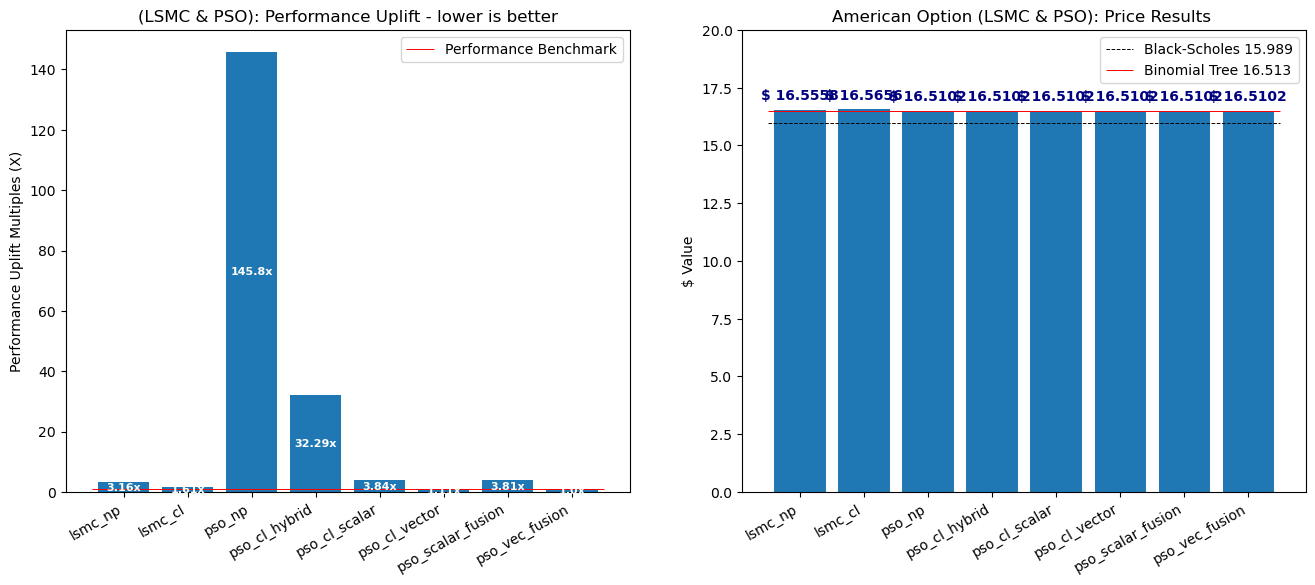

In [85]:
blackscholes, _ = bm.blackScholes(S0, K, r, sigma, T, opttype)
binomial, _ = bm.binomialAmericanOption(S0, K, r, sigma, nPeriod, T, opttype)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

elapses = np.array(elapses)
uplift = list(np.round(elapses / np.min(elapses), 2))

bar1 = ax1.bar(np.arange(len(prices)), uplift)
ax1.set_title('(LSMC & PSO): Performance Uplift - lower is better')
ax1.set_ylabel('Performance Uplift Multiples (X)')
ax1.set_xticks(np.arange(len(prices)), labels=labels, rotation=30, horizontalalignment='right')
ax1.bar_label(bar1, fmt='{}x', label_type='center', color='white', fontsize = 8, fontweight = 'bold')
ax1.hlines(1, -.5, 7.5, colors='r', lw=.7, label='Performance Benchmark') 
ax1.legend()

bar2 = ax2.bar(np.arange(len(prices)), prices)
ax2.set_title('American Option (LSMC & PSO): Price Results ')
ax2.set_ylabel('$ Value')
ax2.set_xticks(np.arange(len(prices)), labels=labels, rotation=30, horizontalalignment='right')
ax2.set_ylim(ymax=20)
ax2.bar_label(bar2, fmt='$ %.4f', label_type='edge', rotation=0, color='navy', fontsize = 10, padding=5, fontweight = 'bold')
ax2.hlines(blackscholes, -.5, 7.5, colors='black', lw=.7, linestyles='dashed', label=f'Black-Scholes {np.round(blackscholes,4)}') 
ax2.hlines(binomial, -.5, 7.5, colors='r', lw=.7, label=f'Binomial Tree {np.round(binomial,4)}') 
ax2.legend()

plt.show()

Black-Scholes price: 15.989035403985838 - 0.15183293726295233 ms
Binomial American price: 16.513004914214047 - 3.2830829732120037 ms


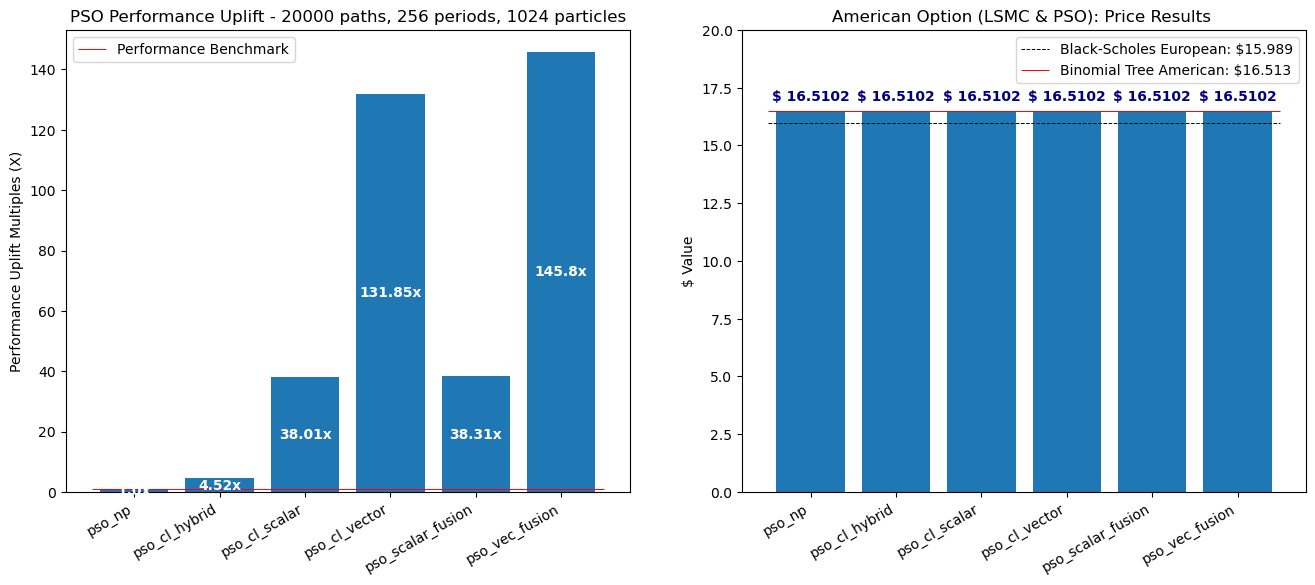

In [86]:
blackscholes, _ = bm.blackScholes(S0, K, r, sigma, T, opttype)
binomial, _ = bm.binomialAmericanOption(S0, K, r, sigma, nPeriod, T, opttype)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

elapses_pso = elapses[2:]
prices_pso = prices[2:]
labels_pso = labels[2:]
uplift = list(np.round(np.max(elapses_pso) / elapses_pso, 2))

bar1 = ax1.bar(np.arange(len(prices_pso)), uplift)
ax1.set_title(f'PSO Performance Uplift - {nPath} paths, {nPeriod} periods, {nFish} particles')
ax1.set_ylabel('Performance Uplift Multiples (X)')
ax1.set_xticks(np.arange(len(prices_pso)), labels=labels_pso, rotation=30, horizontalalignment='right')
ax1.bar_label(bar1, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
ax1.hlines(1, -.5, 5.5, colors='r', lw=.7, label='Performance Benchmark') 
ax1.legend()

bar2 = ax2.bar(np.arange(len(prices_pso)), prices_pso)
ax2.set_title('American Option (LSMC & PSO): Price Results ')
ax2.set_ylabel('$ Value')
ax2.set_xticks(np.arange(len(prices_pso)), labels=labels_pso, rotation=30, horizontalalignment='right')
ax2.set_ylim(ymax=20)
ax2.bar_label(bar2, fmt='$ %.4f', label_type='edge', rotation=0, color='navy', fontsize = 10, padding=5, fontweight = 'bold')
ax2.hlines(blackscholes, -.5, 5.5, colors='black', lw=.7, linestyles='dashed', label=f'Black-Scholes European: ${np.round(blackscholes,4)}') 
ax2.hlines(binomial, -.5, 5.5, colors='r', lw=.7, label=f'Binomial Tree American: ${np.round(binomial,4)}') 
ax2.legend()

plt.show()

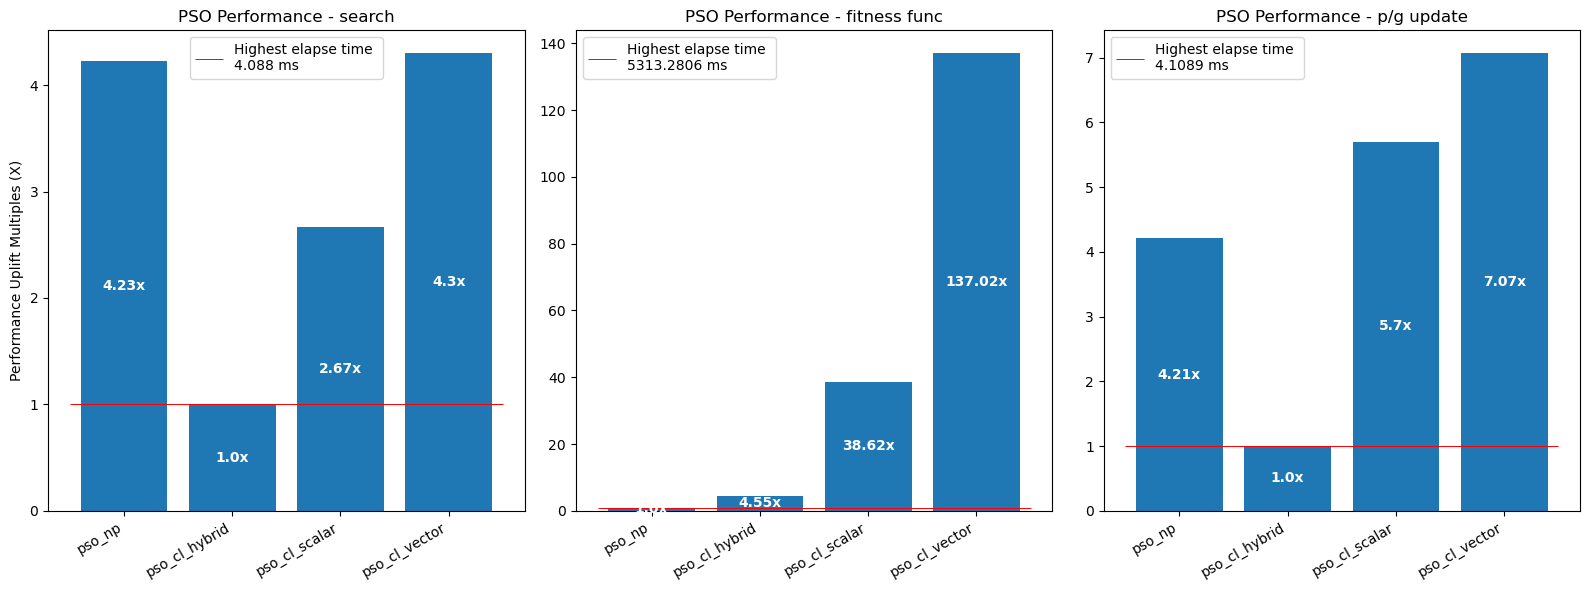

In [87]:
def multiple(a_list):
    arr = np.array(a_list)
    # return list(np.round(arr / np.min(arr), 2))
    return list(np.round(np.max(arr) / arr, 2))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))

bar1 = ax1.bar(np.arange(len(pso_search)), multiple(pso_search))
ax1.set_title('PSO Performance - search')
ax1.set_ylabel('Performance Uplift Multiples (X)')
ax1.set_xticks(np.arange(len(pso_search)), labels=labels_pso[0:-2], rotation=30, horizontalalignment='right')
ax1.bar_label(bar1, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
# ax1.text(2, 2., f'Highest time \n{np.round(np.array(pso_search).max(),4)} ms', color = 'red', fontsize=12)
ax1.hlines(1, -.5, 3.5, colors='r', lw=.7, label=f'Highest elapse time \n{np.round(np.array(pso_search).max(),4)} ms') 
ax1.legend()

bar2 = ax2.bar(np.arange(len(pso_fit)), multiple(pso_fit))
ax2.set_title('PSO Performance - fitness func')
ax2.set_xticks(np.arange(len(pso_fit)), labels=labels_pso[0:-2], rotation=30, horizontalalignment='right')
ax2.bar_label(bar2, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
# ax2.text(2, 20., f'Highet time \n{np.round(np.array(pso_fit).max(),6)} ms', color = 'red', fontsize=12)
ax2.hlines(1, -.5, 3.5, colors='r', lw=.7, label=f'Highest elapse time \n{np.round(np.array(pso_fit).max(),4)} ms') 
ax2.legend()

bar3 = ax3.bar(np.arange(len(pso_update)), multiple(pso_update))
ax3.set_title('PSO Performance - p/g update')
ax3.set_xticks(np.arange(len(pso_update)), labels=labels_pso[0:-2], rotation=30, horizontalalignment='right')
ax3.bar_label(bar3, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
# ax3.text(1.5, 2., f'Highet time \n{np.round(np.array(pso_update).max(),6)} ms', color = 'red', fontsize=12)
ax3.hlines(1, -.5, 3.5, colors='r', lw=.7, label=f'Highest elapse time \n{np.round(np.array(pso_update).max(),4)} ms') 
ax3.legend()

plt.tight_layout()
plt.show()

In [90]:
labels_pso[-2:], elapses_pso[-2:]

(['pso_scalar_fusion', 'pso_vec_fusion'], array([416.26170801, 109.368167  ]))